# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 2: Reorganise the OpenPose JSON wire frame data

This script uses output from [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) human figure recognition neural network to create labeled wireframes for each figure in each frame of a video. It uses the Python API version of OpenPose.

Points are labelled as so:
```
COCO Output Format
Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
Left Ear – 17, Background – 18
```

The `write_json flag` saves the people pose data using a custom JSON writer. Each JSON file has a people array of objects, where each object has:

> An array pose_keypoints_2d containing the body part locations and detection confidence formatted as x1,y1,c1,x2,y2,c2,.... The coordinates x and y can be normalized to the range [0,1], [-1,1], [0, source size], [0, output size], etc., depending on the flag keypoint_scale (see flag for more information), while c is the confidence score in the range [0,1].

In [2]:
import os
import math
import glob
import json
import cv2  #computervision toolkit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
nPoints = 18

# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

pointcolors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

#will colour each person 0:9 a different colour to help us keep track
personcolours = [ [255,0,0], [0,255,0], [0,0,255],[0,255,255], [255,0,255], [255,255,0],[128,255,255], [255,128,255], [255,255,128],[0,0,0]]

#useful to have the indices of the x & y coords and the confidence scores 
#recall that we get them in the order [x0,y0,c0,x1,y1,c1,x2,etc]
xs = [0+3*i for i in range(nPoints)]
ys = [1+3*i for i in range(nPoints)]
cs = [2+3*i for i in range(nPoints)]

In [4]:
#use glob to get all the individual json files.
alljson = glob.glob("output/attachment_avoidant*.json")

In [5]:
nframes = len(alljson) #how many frames in the video?
maxpeople = 10 #maximum people we might expect (large upper bound)
ncoords = 75 #the length of the array coming back from openpose x,y coords of each point plus pafs

keypoints_list = np.zeros([nframes,maxpeople,ncoords]) #big array to hold all the numbers
npeople = np.zeros(nframes)  #how many people detected per frame?
print("This video has {0} frames.".format(nframes))

This video has 1865 frames.


In [6]:
# We will first combine all the data into one giant numpy array. Then we will use this for everything that comes after. 
# such as normalising.. confirming that person 1 is same individal all way through etc.

i = 0
for frame in alljson:
    with open(frame, "r") as read_file:
        data = json.load(read_file)
        j = 0
        for p in data["people"]:
            keypoints = p["pose_keypoints_2d"]  
            keypoints_list[i,j,:]=keypoints
            j += 1
        npeople[i] = j
        i += 1


In [7]:
print(max(npeople))


5.0


In [8]:
#Let's pic a frame a draw the wireframe skeleton
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [36]:
thisframe = 1400
thisperson = 0

1864


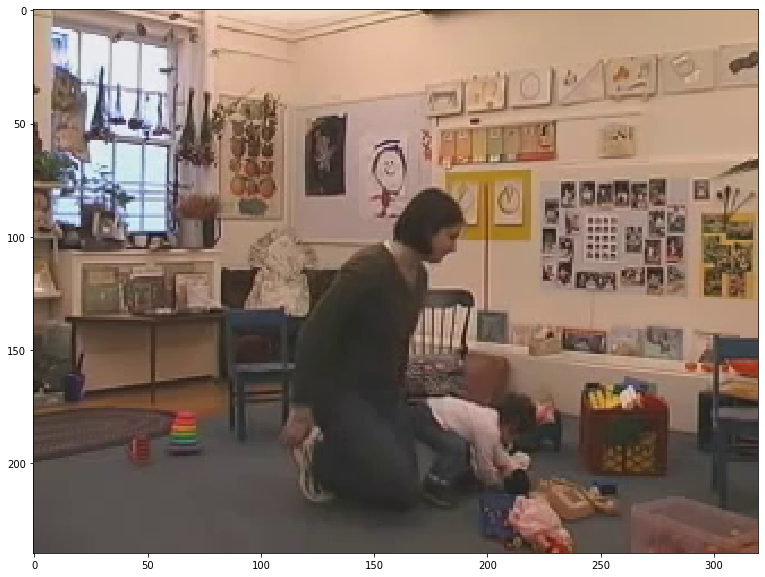

In [37]:
cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

print(total_frames)

framenumber = thisframe
cap.set(cv2.CAP_PROP_POS_FRAMES,framenumber) # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
#cv2.imwrite("frame%#05d.jpg" % (framenumber+1), frame)

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [38]:
print(npeople[thisframe])
print(keypoints_list[thisframe,thisperson,:])



2.0
[1.84959e+02 1.03753e+02 8.64739e-01 1.58955e+02 1.14147e+02 7.60687e-01
 1.48594e+02 1.12240e+02 7.36599e-01 1.23272e+02 1.42712e+02 7.39721e-01
 1.18056e+02 1.73915e+02 8.05103e-01 1.69362e+02 1.16093e+02 7.24981e-01
 1.59629e+02 1.49874e+02 9.90712e-02 1.66764e+02 1.60268e+02 5.27169e-02
 1.45972e+02 1.69378e+02 5.63058e-01 1.37512e+02 1.69364e+02 5.72809e-01
 1.63490e+02 2.10260e+02 7.19985e-01 1.26475e+02 1.94695e+02 7.10570e-01
 1.54424e+02 1.70015e+02 4.91024e-01 1.87539e+02 1.90784e+02 2.99480e-01
 1.78460e+02 2.07022e+02 2.26551e-01 1.84313e+02 9.98699e+01 8.83832e-01
 0.00000e+00 0.00000e+00 0.00000e+00 1.74539e+02 9.66111e+01 8.25374e-01
 0.00000e+00 0.00000e+00 0.00000e+00 1.82347e+02 2.14157e+02 1.71734e-01
 1.82336e+02 2.13512e+02 1.64278e-01 1.73895e+02 2.09633e+02 1.99576e-01
 1.27135e+02 2.11569e+02 6.37698e-01 1.22613e+02 2.10251e+02 5.28744e-01
 1.21942e+02 1.90135e+02 6.33924e-01]


In [12]:
def getkeypointcoord(keypointlist,index):
    x = index * 3
    #some shuffling around to get coords in right format for plotting.
    coords = keypointlist[x:x+2]
    coords = map(int,coords)
    coords = tuple(coords)
    return coords

def averagePoint(keypointList,indices):
    """Function to find the "centre of mass" for this person.
    It will take the average of the non-zero keypoints
    Args:
        keypointList: 1d array of keypoints.
        indices: a set of indices to average over.
    Returns:
        Average
    """
    tot = 0
    N = 0
    for i in indices:
        if keypoints[i]>0:
            tot += keypoints[i]
            N += 1
    return tot / N

def diffKeypoints(keypoints1,keypoints2,indices):
    """Function to find how far apart one set of points is from another.
    This is useful for seeing if we have same person labelled correctly
    from one frame to next. If any point goes out of frame (loc == 0)
    then we don't include that pair. 
    Args:
        keypoints1: 1st array of keypoints.
        keypoints2: 1st array of keypoints.
        indices: a set of indices to compare over.
    Returns:
        diff per index (if any i)
    """
    out = []
    for i in indices:
        if keypoints1[i]>0 and keypoints2[i]:
            out.append(keypoints1[i] - keypoints2[i])
        else:
            out.append(None)
    return out

157.78323529411762
151.82358823529412
0.5927235941176472
197.93321428571429
189.31371428571427
0.3198619714285715


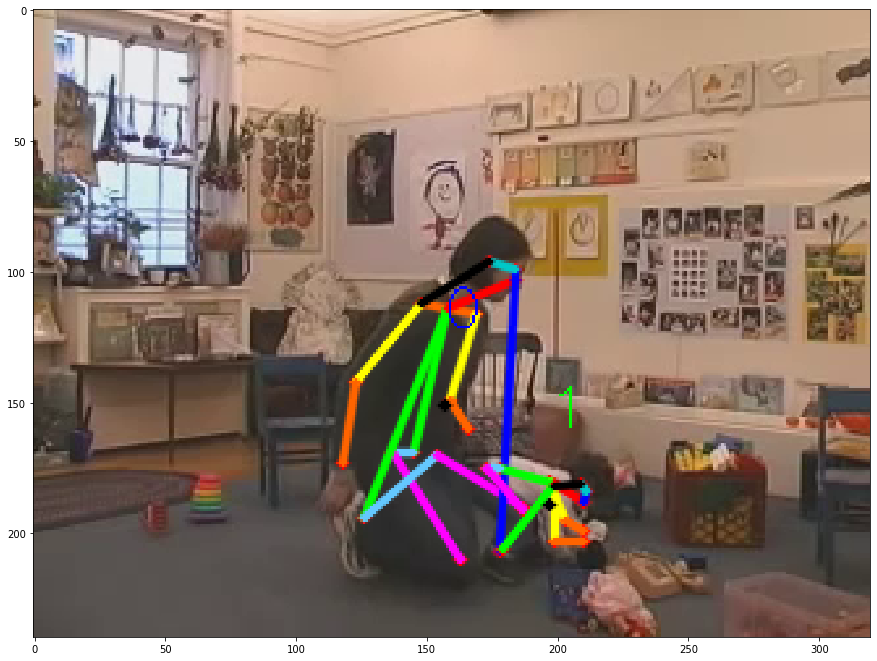

In [43]:
frameClone = frame.copy()
for pers in range(int(npeople[thisframe])):
    keypoints = keypoints_list[thisframe,pers,:]
    for i in range(nPoints):
        coords = getkeypointcoord(keypoints,i)
        if sum(coords) > 0:
            cv2.circle(frameClone,coords, 2, [0,0,255], -1, cv2.LINE_AA)

    for i in range(nPoints):
        l = POSE_PAIRS[i]
        A = getkeypointcoord(keypoints,l[0])
        B = getkeypointcoord(keypoints,l[1])
        if sum(A) > 0 and sum(B) > 0:
            cv2.line(frameClone, (A[0], A[1]), (B[0], B[1]), pointcolors[i], 2, cv2.LINE_AA)    
     
    avx = averagePoint(keypoints,xs)
    avy = averagePoint(keypoints,ys)
    print(avx)
    print(avy)
    print(averagePoint(keypoints,cs))

    cgloc  = tuple((int(avx),int(avy)))
    txtloc = tuple((int(avx),int(avy) - 30))
    cv2.circle(frameClone,cgloc, 2, [0,0,0], -1, cv2.LINE_AA)
    cv2.putText(frameClone, str(pers), txtloc, font, fontScale, personcolours[pers])

plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [ ]:
plt.clf() 



    

plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])


In [41]:
npeople[thisframe]

2.0

[226.54  231.705 233.    225.871 216.767 231.055 231.061 220.682 234.96
 236.258 216.771   0.    233.016 220.009   0.    225.877 231.038   0.   ]
227.64066666666668
186.7198
0.6385175266666666
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, None, 0.0, 0.0, None]


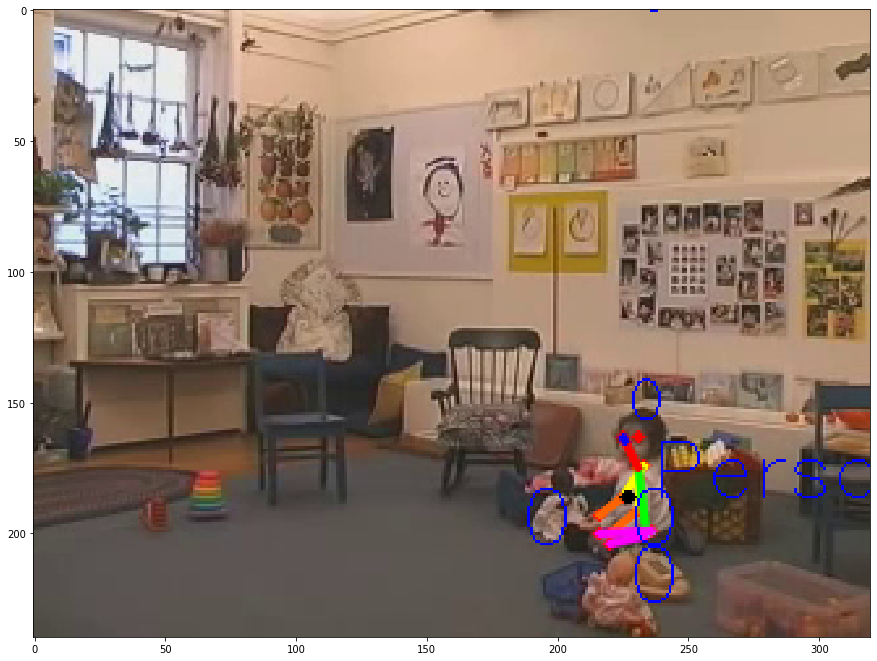

In [35]:


# font 
font = cv2.FONT_HERSHEY_SIMPLEX   
# fontScale 
fontScale = .7
# Blue color in BGR 
color = (255, 0, 0) 


plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [ ]:
with open("attachment_avoidant_AGRT6VjnTm8_360p_000000000181_keypoints.json", "r") as read_file:
    data = json.load(read_file)
    

detected_keypoints = []
keypoints_list = np.zeros((1,18*3))
keypoint_id = 0
threshold = 0.1

for p in data["people"]:
    keypoints = p["pose_keypoints_2d"]        
    keypoint_id = 0
    keypoints_with_id = []
    keypoints_list = keypoints
    for part in range(nPoints):
        thisone =  {keypointsMapping[part] : {"x" : keypoints[keypoint_id], "y" : keypoints[keypoint_id + 1], "conf" : keypoints[keypoint_id + 2]}}
        keypoints_with_id.append(thisone)
        keypoint_id += 3
    #print(keypoints_with_id)
    print(keypoints_list)



In [ ]:
cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    cv2.imshow('frame',frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:


cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

print(total_frames)

framenumber = 1000
cap.set(cv2.CAP_PROP_POS_FRAMES,framenumber) # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
#cv2.imwrite("frame%#05d.jpg" % (framenumber+1), frame)

cv2.imshow('babies', frame)
cv2.waitKey(0)

In [ ]:
# cv2.imshow('babies', frame)

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import time
import os


In [ ]:
video_to_frames("attachment_avoidant_AGRT6VjnTm8_360p.mp4", "./frames/")